# Modelling the behavior of a damped double pendulum

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle
from sklearn import preprocessing

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
raw_data = pd.read_csv("data/spots_e.csv", na_filter=False, usecols=[2,4,5,7])

# The first 5 rows of the csv
print(raw_data.head(5))

spots = raw_data.values
print("Numer of spots:", len(spots)/3)

   TRACK_ID  POSITION_X  POSITION_Y  POSITION_T
0         1     123.907      25.849           0
1         2     266.186      26.386           0
2         0       8.104      22.640           0
3         1     123.899      26.634           1
4         0       8.135      23.067           1
Numer of spots: 49985.0


In [3]:
origin = []
top = []
bottom = []

for spot in spots:
    spot_coord = [spot[1], spot[2]]
    if spot[0] == 2:
        origin.append(spot_coord)
    elif spot[0] == 1:
        top.append(spot_coord)
    else:
        bottom.append(spot_coord)
        
origin, top, bottom = np.array(origin), np.array(top), np.array(bottom)

In [4]:
FPS = 164
time = np.arange(0, len(origin)/FPS, 1/FPS)
print('Length of data:', len(origin))
print('Length of time:', len(time))

Length of data: 49985
Length of time: 49985


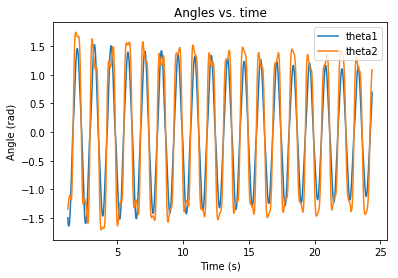

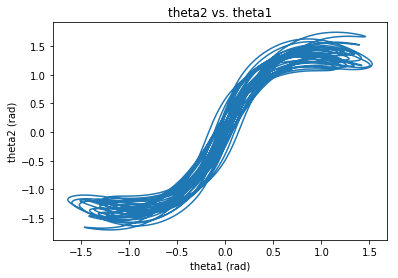

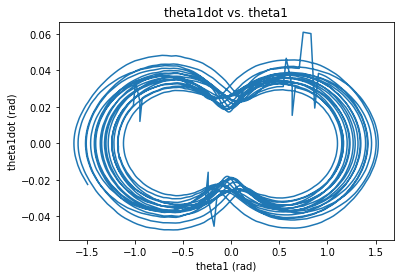

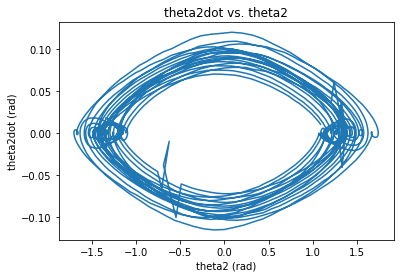

In [36]:
def coord2angle(x):
    slope = x[0] / x[1]
    base = np.arctan(slope)
    if x[0] >= 0 and x[1] >= 0:
        angle = base
    elif x[0] >= 0 and x[1] < 0:
        angle = base + np.pi
    elif x[0] < 0 and x[1] >= 0:
        angle = base
    else:
        angle = base - np.pi
    return angle

top_norm = top - origin
bottom_norm = bottom - top
theta1 = [coord2angle(coord) for coord in top_norm]
theta2 = [coord2angle(coord) for coord in bottom_norm]
theta1dot = np.gradient(theta1)
theta2dot = np.gradient(theta2)

a = 200
b = 4000

plt.figure()
plt.plot(time[a:b], theta1[a:b], label='theta1')
plt.plot(time[a:b], theta2[a:b], label='theta2')
plt.title('Angles vs. time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

plt.figure()
plt.plot(theta1[a:b], theta2[a:b])
plt.title('theta2 vs. theta1')
plt.xlabel('theta1 (rad)')
plt.ylabel('theta2 (rad)')

plt.figure()
plt.plot(theta1[a:b], theta1dot[a:b])
plt.title('theta1dot vs. theta1')
plt.xlabel('theta1 (rad)')
plt.ylabel('theta1dot (rad)')

plt.figure()
plt.plot(theta2[a:b], theta2dot[a:b])
plt.title('theta2dot vs. theta2')
plt.xlabel('theta2 (rad)')
plt.ylabel('theta2dot (rad)')

theta_pair = [[x[0], x[1]] for x in zip(theta1, theta2)]
data = np.array(theta_pair[a:b])

In [37]:
# from scipy.integrate import odeint
# import matplotlib.pyplot as plt
# from matplotlib.patches import Circle

# # Pendulum rod lengths (m), bob masses (kg).
# L1, L2 = 0.02785, 0.0251
# m1, m2 = 0.399, 0.276
# # The gravitational acceleration (m.s-2).
# g = 9.81

# def deriv(y, t, L1, L2, m1, m2):
#     """Return the first derivatives of y = theta1, z1, theta2, z2."""
#     theta1, z1, theta2, z2 = y

#     c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

#     theta1dot = z1
#     z1dot = (m2*g*np.sin(theta2) - m2*s*(L1*z1**2*c + L2*z2**2) -
#              (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
#     theta2dot = z2
#     z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
#              m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
#     return theta1dot, z1dot, theta2dot, z2dot

# # Maximum time, time point spacings and the time grid (all in s).
# tmax, dt = 4, 0.001
# t = np.arange(0, tmax+dt, dt)
# # Initial conditions.
# div1 = 2
# div2 = 2
# y0 = [np.pi/div1, 0, np.pi/div2, 0]

# # Do the numerical integration of the equations of motion
# y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))
# # Unpack z and theta as a function of time
# theta1, theta1dot, theta2, theta2dot  = y[:,0], y[:,1], y[:,2], y[:,3]

# a = 0
# b = -1

# plt.figure()
# plt.plot(theta1[a:b], label='theta1')
# plt.plot(theta2[a:b], label='theta2')
# plt.title('Angles vs. time')
# plt.xlabel('Time (s)')
# plt.ylabel('Angle (rad)')
# plt.legend()

# plt.figure()
# plt.plot(theta1[a:b], theta2[a:b])
# plt.title('theta2 vs. theta1')
# plt.xlabel('theta1 (rad)')
# plt.ylabel('theta2 (rad)')

# plt.figure()
# plt.plot(theta1[a:b], theta1dot[a:b])
# plt.title('theta1dot vs. theta1')
# plt.xlabel('theta1 (rad)')
# plt.ylabel('theta1dot (rad)')

# plt.figure()
# plt.plot(theta2[a:b], theta2dot[a:b])
# plt.title('theta2dot vs. theta2')
# plt.xlabel('theta2 (rad)')
# plt.ylabel('theta2dot (rad)')

In [38]:
# window = 1
# edge = int(np.ceil(window/2))

# def preprocess(data):
#     # Calculate the moving average
#     data = data.rolling(window=window,center=True).mean()
#     # Trim the data that wasn't part of the moving average
#     data = data[edge:-edge]
#     # Standardize the data
#     return preprocessing.scale(data) 

# time_data = raw_data["VideoAnalysis: Time (s)"][edge:-edge].values
# X_data = preprocess(raw_data["VideoAnalysis: X"])
# Y_data = preprocess(raw_data["VideoAnalysis: Y"])

# a = 2
# b = 680
# data = X_data[a:b]
# time = time_data[a:b]
# plt.figure(figsize=(20,10))
# # plt.plot(x)
# plt.plot(time, data)

In [39]:
# hyperparameters
DATA_DIM = 2
N_PREV = 220 # number of previous steps used to predict the next step

In [40]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    docX, docY = [], []
    for j in range(len(data)-n_prev):
        docX.append(data[j:j+n_prev])
        docY.append(data[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], DATA_DIM), alsY.reshape(alsY.shape[0], DATA_DIM)

def train_test_split(data, test_size=0.6):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * (1 - test_size)))

    X_train, y_train = _load_data(data[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(data[ntrn:])

    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.5)

In [41]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=200, return_sequences=True), input_shape=(None, DATA_DIM)))
model.add(Bidirectional(CuDNNLSTM(units=100, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(units=50, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=2, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [42]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.05)

Train on 1596 samples, validate on 84 samples
Epoch 1/30
1596/1596 [==============================] - 11s 7ms/step - loss: 0.0655 - val_loss: 0.0084
Epoch 2/30
1596/1596 [==============================] - 10s 6ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 3/30
1596/1596 [==============================] - 10s 6ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 4/30
1596/1596 [==============================] - 10s 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/30
1596/1596 [==============================] - 10s 6ms/step - loss: 0.0013 - val_loss: 9.7298e-04
Epoch 6/30
1596/1596 [==============================] - 10s 6ms/step - loss: 8.0625e-04 - val_loss: 0.0015
Epoch 7/30
1596/1596 [==============================] - 10s 6ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/30
1596/1596 [==============================] - 10s 6ms/step - loss: 8.8668e-04 - val_loss: 0.0017
Epoch 9/30
1596/1596 [==============================] - 10s 6ms/step - loss: 7.2070e-04 - val_loss: 4.1902e-04
Epoch 1

dict_keys(['val_loss', 'loss'])
30


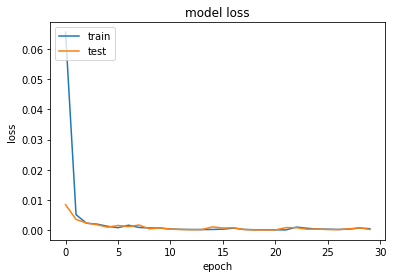

In [43]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][-30:])
plt.plot(history.history['val_loss'][-30:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
# evaluate model fit
test_prediction = model.predict(X_test)
# score = model.evaluate(X_test, y_test)
# evaluate
print('Test score:', np.mean((test_prediction-y_test)**2))

Test score: 0.00022589152422826676


In [45]:
# generate the time axis for visualization
t_step = np.mean(time[1:]-time[:-1])
t_start = time[-len(y_test)]

def gen_time(data):
    t = np.arange(t_start, t_start+len(data)*t_step, t_step)
    return t

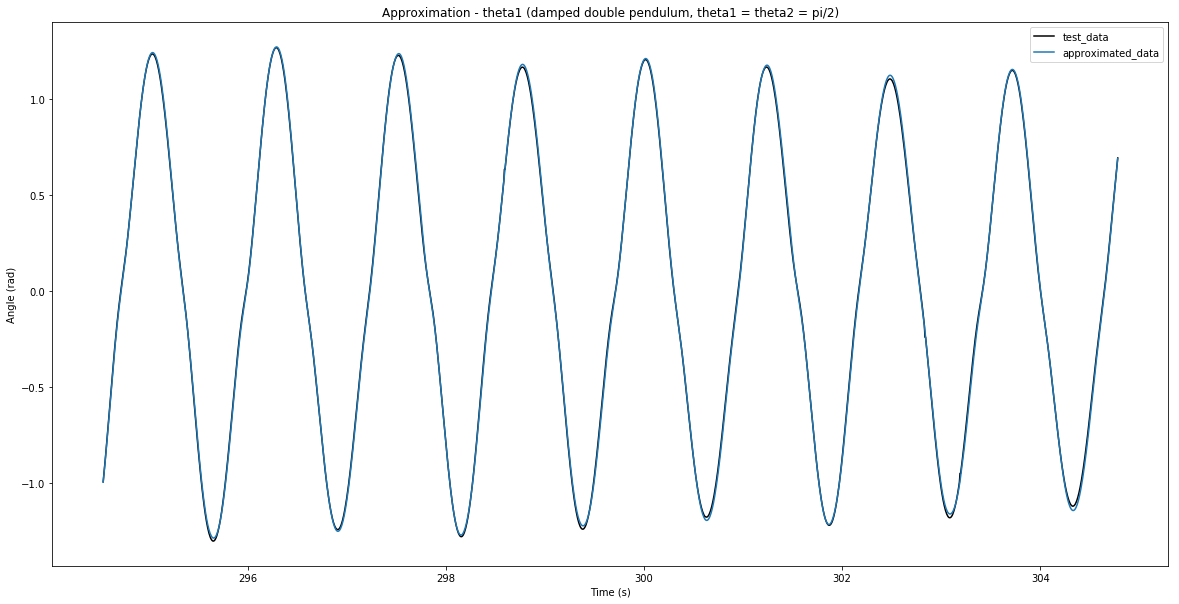

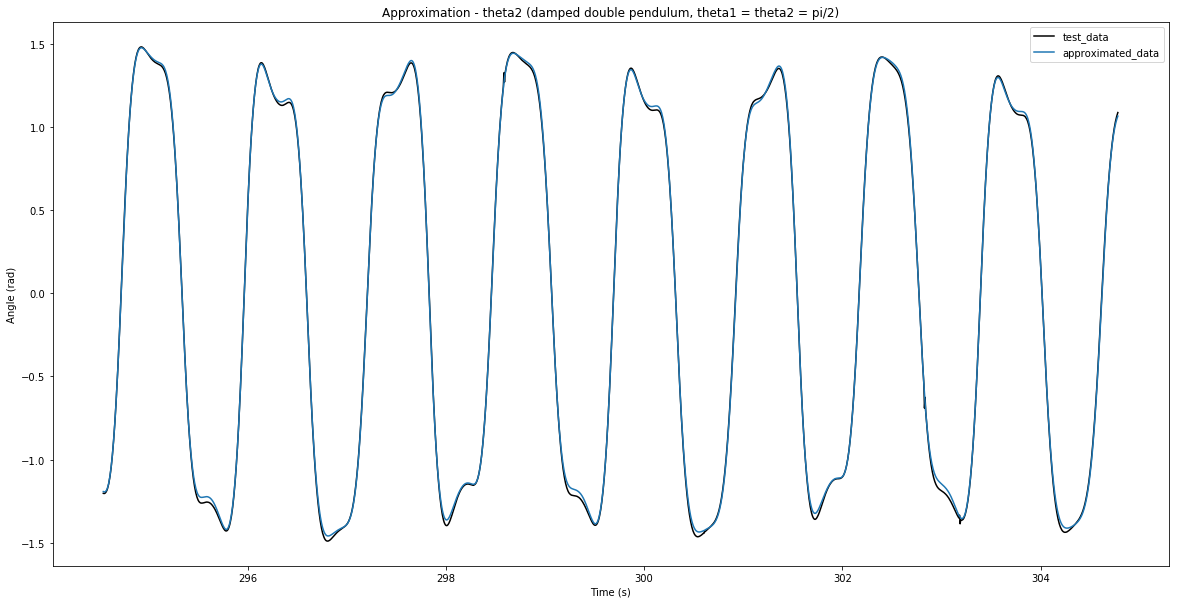

In [54]:
# visualize approximation performance on test data set
t1 = gen_time(y_test)[:len(y_test)]

plt.figure(figsize=(20,10))
plt.plot(t1, y_test[:,0], label='test_data', color='k')
plt.plot(t1, test_prediction[:,0], label='approximated_data')
plt.title('Approximation - theta1 (damped double pendulum, theta1 = theta2 = pi/2)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t1, y_test[:,1], label='test_data', color='k')
plt.plot(t1, test_prediction[:,1], label='approximated_data')
plt.title('Approximation - theta2 (damped double pendulum, theta1 = theta2 = pi/2)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

In [47]:
# perform modelling
test_data = y_test

X_model = X_test[0] if np.array_equal(test_data, y_test) else data[0:N_PREV]
modelled_data = []
dims = 1, X_model.shape[0], DATA_DIM

prediction_steps = len(test_data) - (0 if np.array_equal(test_data, y_test) else N_PREV)

for i in range(prediction_steps * 2):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(list(next_step[0]))
    X_model = np.append(X_model[1:], next_step, axis=0)
    
# evaluate
modelled_data = np.array(modelled_data) if np.array_equal(test_data, y_test) else np.append(data[0:N_PREV], modelled_data, axis=0)
print('Prediction score:', np.mean((modelled_data[:len(test_data)]-test_data)**2))

Prediction score: 0.09546824452932613


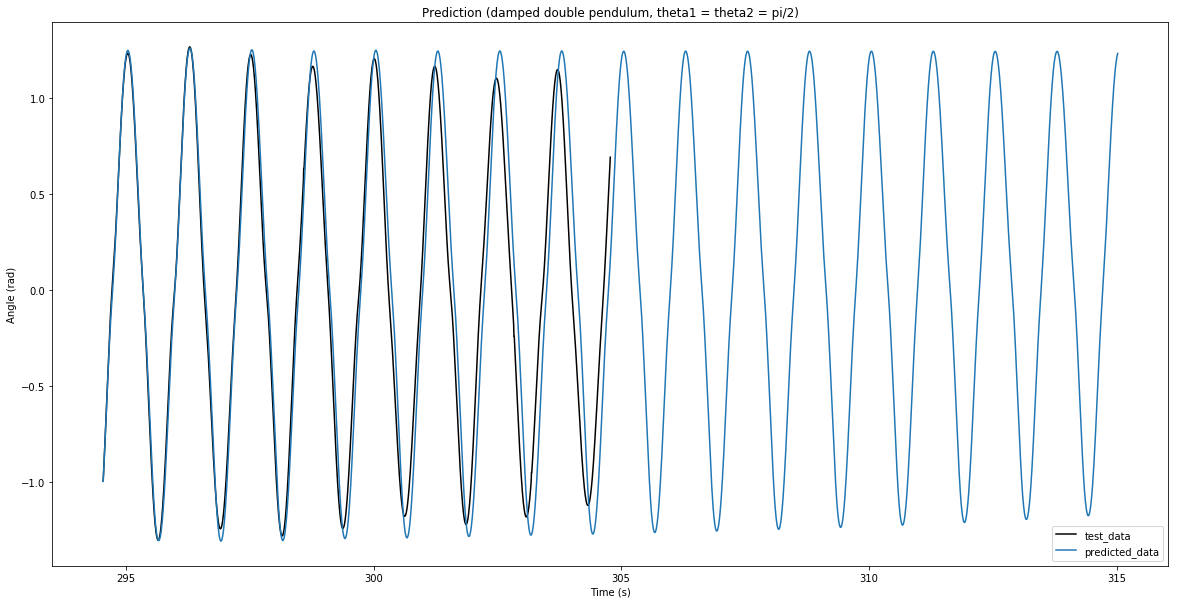

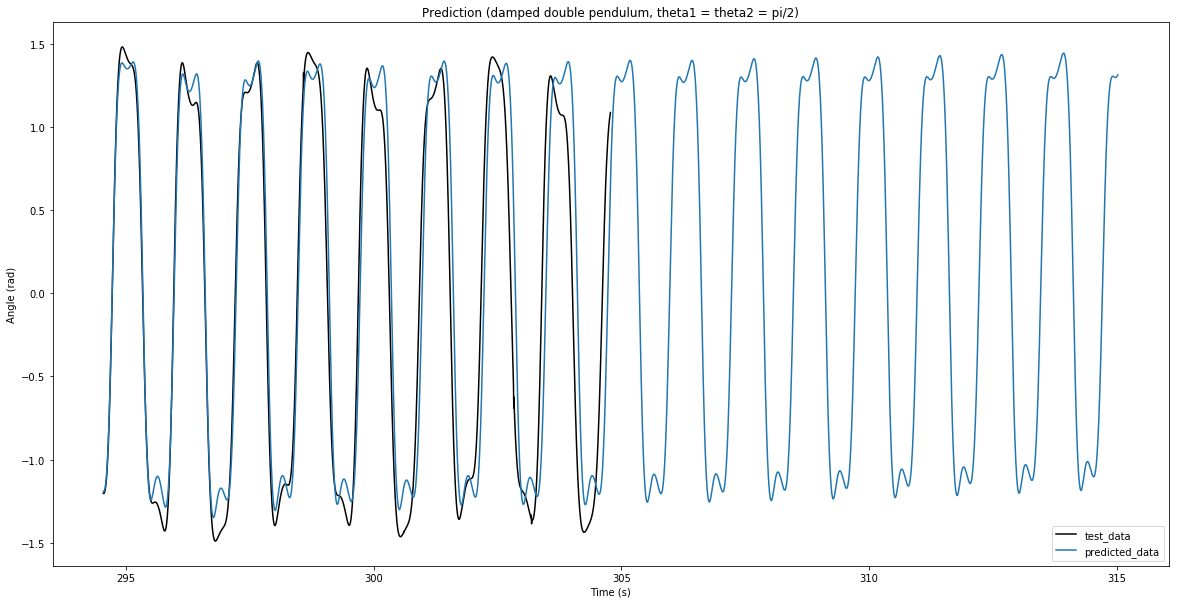

In [53]:
# visualize prediction performance
t_start = time[-len(test_data)] if np.array_equal(test_data, y_test) else time[a]
t2 = np.arange(t_start, t_start+len(modelled_data)*t_step, t_step)
t2 = t2[:len(modelled_data)]

plt.figure(figsize=(20,10))
if np.array_equal(test_data, y_test):
    plt.plot(t1, y_test[:,0], label='test_data', color='k')
else:
    plt.plot(time[a:b], data[:,0], label='train_data', color='k')
plt.plot(t2, modelled_data[:,0], label='predicted_data')
plt.title('Prediction - theta1 (damped double pendulum, theta1 = theta2 = pi/2)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

plt.figure(figsize=(20,10))
if np.array_equal(test_data, y_test):
    plt.plot(t1, y_test[:,1], label='test_data', color='k')
else:
    plt.plot(time[a:b], data[:,1], label='train_data', color='k')
plt.plot(t2, modelled_data[:,1], label='predicted_data')
plt.title('Prediction - theta2 (damped double pendulum, theta1 = theta2 = pi/2)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

In [35]:
# visualize approximations
train_prediction = model.predict(X_train)

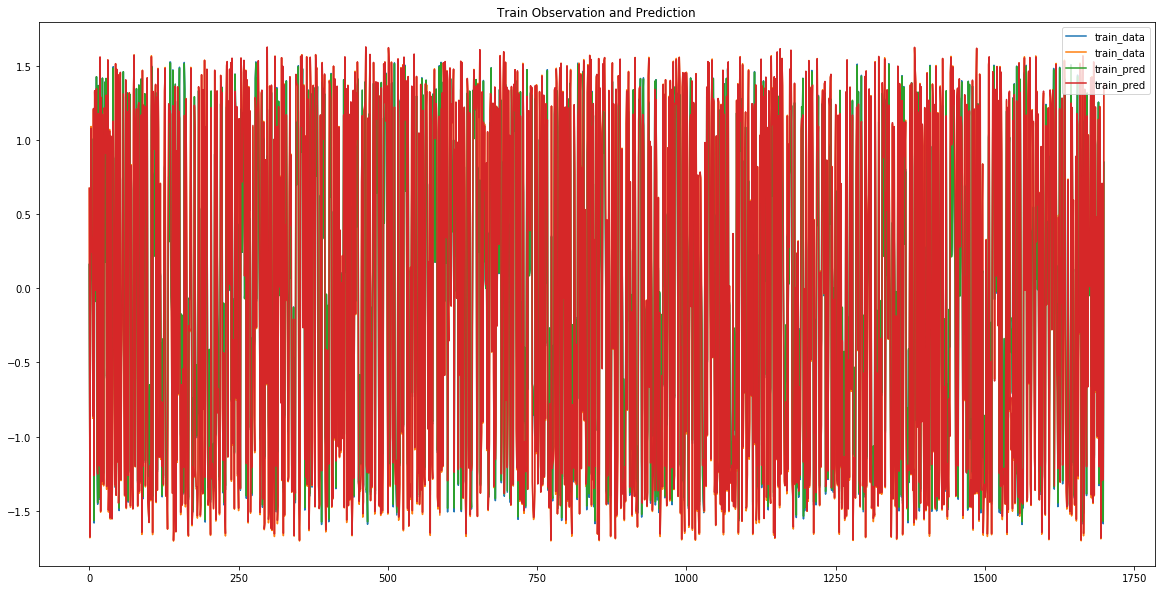

In [235]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()